In [1]:
import numpy as np

x = np.random.randn(10, 1, 28, 28)
x.shape


(10, 1, 28, 28)

In [2]:
x[0].shape

(1, 28, 28)

In [3]:
x[1].shape

(1, 28, 28)

In [4]:
x[0,0]

array([[-3.64728621e-01, -7.51978664e-01,  1.62427887e+00,
         3.47114022e-01,  1.56944838e-01, -1.27468304e+00,
         1.16884674e-01, -1.01647176e+00, -6.69748988e-02,
        -1.48213493e+00,  7.48471102e-01, -3.57560650e-01,
        -3.13745364e-01, -2.26625816e-01, -1.04910653e-01,
         8.15905769e-01,  2.02040913e-01,  9.16141810e-01,
        -8.23548666e-01, -1.69189145e+00,  1.96698916e+00,
         6.79130575e-01, -3.50853706e-01, -9.19325704e-01,
         1.42429208e+00,  3.89638617e-01,  2.78017235e-01,
         2.75082644e-01],
       [ 6.44715965e-01,  1.02210747e+00, -6.83771595e-01,
         6.64526617e-01, -7.06986859e-01,  8.29532010e-02,
         1.46312044e+00,  1.35326283e+00,  4.04558358e-02,
         7.89808621e-01, -4.90338295e-01,  4.12504575e-01,
         1.99813675e-02, -3.06733845e-02,  1.98097864e-01,
         5.81690057e-01,  1.38271387e-01, -1.70479567e+00,
        -1.84752267e-01, -1.29838805e+00,  2.31681825e-01,
         4.84538636e-01, -1.46

In [5]:
#im2col 함수 
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """(im2col과 반대) 2차원 배열을 입력받아 다수의 이미지 묶음으로 변환한다.
    
    Parameters
    ----------
    col : 2차원 배열(입력 데이터)
    input_shape : 원래 이미지 데이터의 형상（예：(10, 1, 28, 28)）
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    img : 변환된 이미지들
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]


In [6]:
import sys, os
sys.path.append(os.pardir)
from common.util import im2col

x1 = np.random.rand(1, 3, 7, 7) #데이터수, 채널수, 높이, 너비 
col1 = im2col(x1, 5, 5, stride = 1, pad = 0)
print(col1.shape)
x2 = np.random.rand(10, 3, 7, 7) #데이터 10개 
col2 = im2col(x2, 5, 5, stride = 1, pad = 0)
print(col2.shape)

(9, 75)
(90, 75)


In [7]:
class Convolution:
    def __init__(self, W, b, stride = 1, pad = 0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1+ (H + 2*self.pad - FH) / self.stride)
        out_w = int(1+ (W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN,-1).T
        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        return out

In [8]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride = 1, pad = 0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride )
        out_w = int(1 + (W - self.pool_w) / self.stride )
        #전개 (1)
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        #최대값(2)
        out = np.max(col, axis = 1)
        #성형(3)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        return out

In [17]:
class SimpleConvNet:
    def __init__(self, input_dim = (1, 28, 28), 
                 conv_param = {'filter_num':30, 'filter_size': 5,
                               'pad':0, 'stride': 1},
                 hidden_size = 100, output_size = 10, weight_init_std = 0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2 * filter_pad) / \
                            filter_stride + 1
        pool_output_size = int(filter_num + (conv_output_size/2) *
                               (conv_output_size/2))
        self.params = {}
        self.params['W1'] = weight_init_std * \
                    np.random.randn(filter_num, input_dim[0],
                                    filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                    np.random.randn(pool_output_size, 
                                    hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                    np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'],
                                           self.params['b1'],
                                           conv_params['stride'],
                                           conv_params['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h = 2, pool_w = 2, stride = 2)
        self.layers['Affine1'] = Affine(self.params['W2'],
                                        self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'],
                                        self.params['b3'])
        self.last_layer = SoftmaxWithLoss()


In [18]:
def predict(self, x):
    for layer in self.layers.values():
        x = layer.forward(x)
    return x
def loss(self, x, t):
    y = self.predict(x)
    return self.last_layer.forward(y, t)


In [ ]:
def gradient(self, x, t):
    #순전파 
    self.loss(x, t)
    #역전파
    dout = 1
    dout = self.last_layer.backward(dout)

    layers = list(self.layers.values())
    layers.reverse()
    for layer in layers:
        dout = layer.backward(dout)
    #결과저장 
    grads = {}
    grads['W1'] = self.layers['Conv1'].dW
    grads['b1'] = self.layers['Conv1'].db
    grads['W2'] = self.layers['Affine1'].dW
    grads['b2'] = self.layers['Affine1'].db
    grads['W3'] = self.layers['Affine2'].dW
    grads['b3'] = self.layers['Affine2'].db
    return grads

In [23]:
import sys, os
sys.path.append(os.pardir)

import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # 순전파
        self.loss(x, t)

        # 역전파
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(os.path.dirname(__file__) + '/' + file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

train loss:2.299896562913861
=== epoch:1, train acc:0.261, test acc:0.314 ===
train loss:2.298274819124026
train loss:2.2926581708615283
train loss:2.2859140022319657
train loss:2.2797625624652524
train loss:2.2668834227582413
train loss:2.2544249108881997
train loss:2.231462270478456
train loss:2.20960712105276
train loss:2.1959278920964125
train loss:2.120582348191513
train loss:2.1033715550481915
train loss:2.0721320053363588
train loss:2.066461943916232
train loss:2.0238423381223685
train loss:1.9467572682789978
train loss:1.9168531897204824
train loss:1.8118325906325565
train loss:1.664493982437444
train loss:1.679203416696537
train loss:1.5519250579332406
train loss:1.379425267305507
train loss:1.3949329621927478
train loss:1.3630575751788603
train loss:1.2397797112714393
train loss:1.127827970006447
train loss:1.0501232775018787
train loss:1.0804683588005404
train loss:0.9709969500077043
train loss:0.8267444719482074
train loss:0.8069262077125805
train loss:0.800048620319561
tra

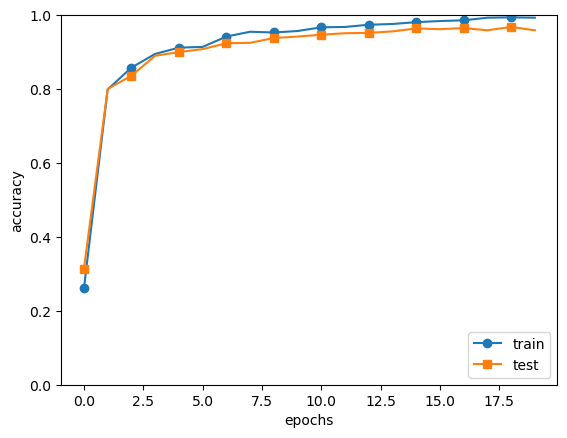

In [26]:
import sys, os
sys.path.append(os.pardir)

import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist

from common.trainer import Trainer

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()